# Applying GrandPrix on the single cell RNA-seq of mouse dendritic cells
_Sumon Ahmed_, 2017, 2018

This notebooks shows how GrandPrix with informative prior over the latent space can be used to infer one dimensional pseudotime from the single cell RNA-seq of the primary bone-marrow-derived dendritic cells of mouse.

In [1]:
import pandas as pd
import numpy as np
from  GrandPrix import GrandPrix

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/24919153" target="_blank">Shalek et al. (2014)</a> generated single cell RNA-seq from the primary bone-marrow-derived dendritic cells of mouse in three different conditions.They described
several modules of genes which show different temporal expression patterns through the lipopolysaccharide stimulated (LPS) time course.

They found two cells captured at the 1 hour mark which switched to this group precociously, i.e. have genes expressed which are not expressed in the other cells of the 1 hour group.

The __ShalekTrainingData.csv__ file contains the expression profiles of the top __74__ variable expressed genes in __307__ cells from the LPS time course which have been used in the inference.

The __ShalekCellMeta.csv__ file contains the additional information of the data such as capture time of each cells, different initializations of pseudotimes, etc.

In [2]:
Y = pd.read_csv('../data/Shalek/ShalekTrainingData.csv', index_col=[0]).T.values
mData = pd.read_csv('../data/Shalek/ShalekCellMeta.csv', index_col=[0])

In [3]:
from sklearn import preprocessing
Y = preprocessing.scale(Y)
N, D = Y.shape
print('Cells: %s, Genes: %s'%(N, D))

Cells: 307, Genes: 74


In [4]:
mData.head()

,c,cell,assay,ko,stimulant,captureActual,replicate,cell.num,obstime,total,...,init_11,init_12,init_13,init_14,init_15,init_16,init_17,init_18,init_19,init_20
1,1,Unstimulated_S15,NaN,NaN,NaN,Unstimulated,NaN,15,0,8930811,...,0.176471,4.124183,3.183007,-0.686275,-0.320261,-0.529412,2.764706,0.202614,-0.686275,-0.686275
2,2,Unstimulated_S16,NaN,NaN,NaN,Unstimulated,NaN,16,0,8438017,...,-0.450980,1.352941,3.000000,-0.555556,-0.790850,-0.921569,3.549020,-0.294118,0.098039,0.437908
3,3,Unstimulated_S17,NaN,NaN,NaN,Unstimulated,NaN,17,0,8517120,...,-0.346405,1.379085,3.810458,-0.764706,0.254902,-0.738562,3.026144,-0.163399,2.032680,0.098039
4,4,Unstimulated_S23,NaN,NaN,NaN,Unstimulated,NaN,23,0,5975840,...,-0.764706,-0.346405,3.679739,-0.032680,0.228758,-0.450980,3.784314,-0.581699,0.437908,2.032680
5,5,Unstimulated_S24,NaN,NaN,NaN,Unstimulated,NaN,24,0,11633075,...,-0.921569,-0.450980,2.895425,-0.398693,-0.006536,-0.346405,2.163399,-0.686275,1.169935,1.169935


## Run the GrandPrix model

Capture time points have been used as the informative prior information over pseudotime. Following arguments have been passed to initialize the model.

<!--
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.
-  __latent_prior_mean__: _array-like, shape N_ x 1, _optional (default:_ __0__). > Mean of the prior distribution over pseudotime.
-  __latent_prior_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Variance of the prior distribution over pseudotime.
-  __latent_mean__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial mean values of the approximate posterior distribution over pseudotime.
-  __latent_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial variance of the approximate posterior distribution over pseudotime.
- __kernel:__ _optional (default: RBF kernel with lengthscale and variance set to 1.0)_. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior.
-->
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __n_inducing_points__: _int_. Number of inducing points.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_var__: _array-like, shape N_ x 1. Variance of the prior distribution over pseudotime.


-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.

<!--
-  __latent_var__: _array-like, shape N_ x 1. Initial variance of the approximate posterior distribution over pseudotime.
-->

- __kernel:__. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior.


-  __inducing_inputs__: _array-like, shape_ _n_\__inducing_\__points_ x 1. Inducing input variables in the space of latent variables. 

In [5]:
latent_dims = 1
M = 30 # number of inducing points

np.random.seed(10)
sigma_t = 1.
prior_mean = mData['capture.orig'].values[:, None]

X_mean = [prior_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)]  # initialisation of latent_mean 

np.random.seed(10)
Z = np.random.rand(M, latent_dims) # initialisation of inducing_inputs 

In [6]:
pt, var = GrandPrix.fit_model(data=Y, n_inducing_points=M, 
                            latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t), 
                            latent_mean=np.asarray(X_mean), 
                            kernel={'name':'Matern32', 'ls':5.0, 'var':1.0}, inducing_inputs=Z, display=True)

Could not find signature for _expectation: <Gaussian, Matern32, NoneType, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, NoneType, NoneType>
Could not find signature for _expectation: <Gaussian, Matern32, InducingPoints, Matern32, InducingPoints>


/home/sumon/newInstall/GPflow/gpflow/expectations.py:110: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 22648.442418
  Number of iterations: 284
  Number of functions evaluations: 332


## Visualize the results
The module score <a href="https://www.ncbi.nlm.nih.gov/pubmed/24919153" target="_blank" style="text-decoration:none">(Shalek et al., 2014)</a> of core antiviral genes have been plotted over the estimated pseudotimes. Each point corresponds to the module score of a cell. 

The points are coloured according to the actual cell capture time.

A Loess curve through the data have been generated by using the R `stat_smooth` function. 

In [ ]:
data = pd.DataFrame({'Pseudotime':pt.reshape(-1), 'Module_score':mData['module.score'], 
                     'capture':mData['obstime'].values, 'type':mData['Precocious'].values})
data=data.sort_values('type', ascending=True)

In [4]:
import readline
import rpy2.robjects
%load_ext rpy2.ipython

In [5]:
%%R
library(ggplot2)

/home/sumon/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `geom_smooth()` using method = 'loess'

  warnings.warn(x, RRuntimeWarning)


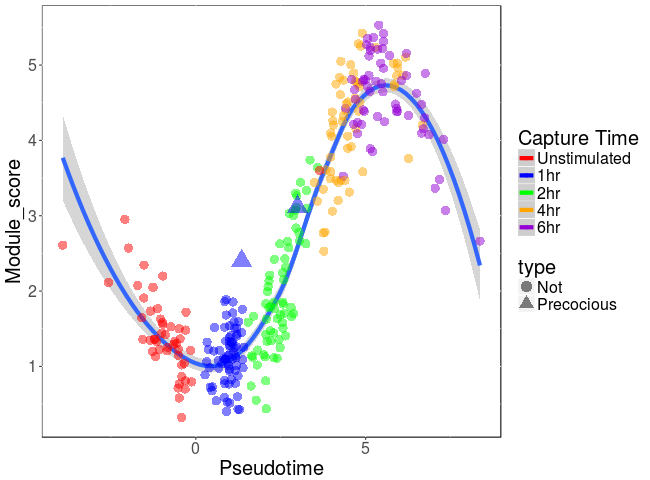

In [6]:
%%R -i data -w 650
head(data)

plots1<-(
    ggplot(data,
           aes(x=Pseudotime, y=Module_score, color=as.factor(capture), shape=type, size=type=='Precocious'))
    + stat_smooth(aes(group="", color=NULL), size=2)
    + scale_size_manual(values=c(4, 7))
    + theme(panel.background = element_rect(fill="white", linetype="solid", color="black"))
    + theme(text = element_text(size=20))
)
plots1 = plots1 + geom_point(alpha=0.5) + scale_colour_manual(name = 'Capture Time', 
         values =c('0'='red','1'='blue','2'='green','4'='orange','6'='darkviolet'), 
                                      labels = c('Unstimulated','1hr','2hr','4hr','6hr'))
plots1 = plots1 + guides(size=FALSE, shape = guide_legend(override.aes = list(size=5)))
print(plots1)